# Analysis of the Lichess games database 

## Installing nescessary tools and modules

In [3]:
# ###### Spark install ######
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark
!pip install pyspark
 
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
 
##### Further packages install ######
!pip install datetime
!pip install -q glob3
!pip install pyarrow==1.0.0
!pip install line_profiler

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic

## Setting up things

### One liner to crash the sessions ram

Currently a colab machine has 15 GB of RAM. If a machine crashed, Google offers more RAM up to 25 GB. So, if nescessary this line can be executed to crash the sessions by calculating a list comprehension (which gives numbers from 0 to 10^10) to increase the available  this can be increased to 25 GB 

In [ ]:
%load_ext autoreload
# %load_ext line_profiler
%autoreload 2
import sys
sys.path.append("./modules/")
from pgn_process import *

## Stream and process archive from Lichess archive server. 
Data of the games can be downloaded from the lichess archive server. As the Lichess platform became very popular within the last years, the number of games grew excessively and an archive from 2020 can easily exceed a size of 10 GB (compressed) or 100 GB (uncompressed). These amount of data cannot be handled directly with the resources Google Colab offers for free. 

Therefore, archives are downloaded and compressed chunkwise within the self-written class pgn_process. The simplified workflow can be described as follows:

1.   The function pgn.process.process_archive() streams the archive directly from the Lichess server.

2.   Chunks of the data stream are decompressed from the bz2 stream and converted to strings.

3.   Strings are analyzed line by line to extract the games meta data in a dictionary.

4.   To avoid out-of-memory errors, the games dictionary is converted to a pandas dataframe and written to a csv, every 1E6 games were processed. This allows reinitializing a new dictionary, keeping the memory used below 2 GB.

5.   Start over with a new chunk in step 1.


After finishing the archive processing, data is read from the csv file by (Py)Spark and written to a parquet structure, which only needs approx. 1/8 of the disk space a csv file needs.  

In [ ]:
file_url = (
    "https://database.lichess.org/standard/lichess_db_standard_rated_2016-11.pgn.bz2"
)
pgn_data = pgn_process(file_url)
pgn_data.process_archive()

pgn_data.csv2parquet()
pgn_data.delete_csv()

Games processed: 100000
Games processed: 200000
Games processed: 300000
Games processed: 400000
Games processed: 500000
Games processed: 600000
Games processed: 700000
Games processed: 800000
Games processed: 900000
Games processed: 1000000
Processed 1017867 games in 96 s
Games processed: 1100000
Games processed: 1200000
Games processed: 1300000
Games processed: 1400000
Games processed: 1500000
Games processed: 1600000
Games processed: 1700000
Games processed: 1800000
Games processed: 1900000
Games processed: 2000000
Processed 1014190 games in 100 s
Games processed: 2100000
Games processed: 2200000
Games processed: 2300000
Games processed: 2400000
Games processed: 2500000
Games processed: 2600000
Games processed: 2700000
Games processed: 2800000
Games processed: 2900000
Games processed: 3000000
Processed 1020694 games in 102 s
Games processed: 3100000
Games processed: 3200000
Games processed: 3300000
Games processed: 3400000
Games processed: 3500000
Games processed: 3600000
Games proce

## Inspecting and cleaning data

After all data from the archive were processed, we start cleaning the data structure using the functions from the self-written class pyspark_processing, which involves mainly checking for missing data and replacing categorial objects by feature ids (mainly user names, as all other categorial features where processed already when extracting the meta data from the archive). 

As one could be interested in analyzing more than a single month, user names and there IDs are saved in an additional parquet structure, which can be expanded over several archives.

### Load data from parquet archive and replace user names by IDs 

In [ ]:
# %reset
import sys
sys.path.append("./modules/")
# sys.path.append("/home/eileen/Dokumente/Stephan/test/")

%load_ext autoreload
%autoreload 2

from pgn_process import *
from pyspark_processing import *


import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

MAX_MEMORY = "8g"
spark = SparkSession.builder.appName("FeatureEng") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()  

processing = pyspark_processing(
  spark = spark, 
  archive_date = "2016-11")

sdf_gamesDB = processing.load_archive()
# sdf = processing.load_archive()

sdf_usersDB = processing.load_UserDB()

sdf_usersArchiv = processing.collect_users(sdf_gamesDB)

sdf_users = processing.join_users(sdf_usersDB, sdf_usersArchiv)

sdf = processing.replace_user_by_ID(archivDB = sdf_gamesDB, usersDB = sdf_users)

### First inspection of the dataframe

In [ ]:
sdf.printSchema()
sdf.cache()
sdf.show()

root
 |-- Result: float (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: float (nullable = true)
 |-- ECO: string (nullable = true)
 |-- TimeControl: float (nullable = true)
 |-- Termination: string (nullable = true)
 |-- PlyCount: float (nullable = true)
 |-- TimeStamp: timestamp (nullable = true)
 |-- White: integer (nullable = true)
 |-- Black: integer (nullable = true)

+------+--------+--------+---+-----------+-----------+--------+-------------------+------+-----+
|Result|WhiteElo|BlackElo|ECO|TimeControl|Termination|PlyCount|          TimeStamp| White|Black|
+------+--------+--------+---+-----------+-----------+--------+-------------------+------+-----+
|  -1.0|    1725|  1833.0|B54|      100.0|          0|    59.0|2016-11-25 13:30:04| 38825|  138|
|   1.0|    1717|  1517.0|C24|      600.0|          0|    42.0|2016-11-29 17:46:25|139604|  408|
|  -1.0|    1539|  1464.0|D00|      600.0|          0|    28.0|2016-11-18 02:23:21| 27363|  408|
|  -1.0|    1761

In [ ]:
sdf.summary().show()

+-------+-------------------+-----------------+------------------+-------+-----------------+-------------------+-----------------+------------------+-----------------+
|summary|             Result|         WhiteElo|          BlackElo|    ECO|      TimeControl|        Termination|         PlyCount|             White|            Black|
+-------+-------------------+-----------------+------------------+-------+-----------------+-------------------+-----------------+------------------+-----------------+
|  count|            7709107|          7709107|           7709107|7709107|          7679893|            7709107|          7709107|           7709107|          7709107|
|   mean|0.03153075965867382| 1704.84199038877|1703.6991547788869|   null|362.3599658224405|0.30874743339273925|35.05377561888815| 83202.38634760161|83042.34885830486|
| stddev| 0.9791078767939906|263.7665304524238| 264.8262443478439|   null|466.7886526339489|0.46249391272434837|15.00780632189725|46263.362116904485|46273.09614

### Counting rows and null-rows

In [ ]:
print("Count of rows with null values")
sdf.select([count(when(isnan(cc) | col(cc).isNull(), cc)).alias(cc) for cc in sdf.drop("TimeStamp").columns]).show()

print("Rows with null values in TimeControl")
sdf.filter("TimeControl is null").show()

# Droping NULLs
sdf = sdf.filter("TimeControl is not null")

sdf.cache()

print("Null rows left (for controlling)")
sdf.select([count(when(isnan(cc) | col(cc).isNull(), cc)).alias(cc) for cc in sdf.drop("TimeStamp").columns]).show()

Count of rows with null values
+------+--------+--------+---+-----------+-----------+--------+-----+-----+
|Result|WhiteElo|BlackElo|ECO|TimeControl|Termination|PlyCount|White|Black|
+------+--------+--------+---+-----------+-----------+--------+-----+-----+
|     0|       0|       0|  0|      29214|          0|       0|    0|    0|
+------+--------+--------+---+-----------+-----------+--------+-----+-----+

Rows with null values in TimeControl
+------+--------+--------+---+-----------+-----------+--------+-------------------+------+-----+
|Result|WhiteElo|BlackElo|ECO|TimeControl|Termination|PlyCount|          TimeStamp| White|Black|
+------+--------+--------+---+-----------+-----------+--------+-------------------+------+-----+
|  -1.0|    1662|  1337.0|B12|       null|          0|    36.0|2016-11-29 19:26:12|  2702| 2643|
|   1.0|    1662|  1337.0|A00|       null|          0|    59.0|2016-11-08 16:32:09|158369|10179|
|   0.0|    1752|  1247.0|A00|       null|          0|    48.0|201

*   No NULL in the dataframe, except in column "TimeControl"
*   Nulls result from games without TimeControl
*   Rows with NULL are dropped as games without TimeControl significantly differ from real games and they make << 1% of the total row number




### Correcting column types
BlackElo: float -> int
TimeControl: float -> int
Termination: string -> int

In [ ]:
output = False

In [ ]:
sdf = sdf.withColumn("BlackElo",col("BlackElo").cast("Integer"))
sdf = sdf.withColumn("TimeControl",col("TimeControl").cast("Integer"))
sdf = sdf.withColumn("Termination",col("Termination").cast("Integer"))

if output == True:
  sdf.show()

## Feature engineering

### Add index column ordered by timestamp

In [ ]:
from pyspark.sql.window import Window as W
from pyspark.sql import functions as F

windowSpec = W.orderBy("TimeStamp")
sdf = sdf.withColumn("idx", F.row_number().over(windowSpec))

if output == True:
  sdf.show()

### Add rating difference

In [ ]:
sdf = sdf.withColumn("EloDiff", col("WhiteElo") - col("BlackElo"))

###  Split result column into binary categorial columns

For improved data handling we split the result column, which contains values 


*   -1 = Black wins -> new col(BWin) = [0, 1] 
*   1 = White wins -> new col(WWin) = [0, 1]
*   0 = Draw -> new col(Draw) = [0, 1]


In [ ]:
sdf = sdf.withColumn(
    "BWin", 
    F.when(
        F.col("Result") == -1, 
        1
    ).otherwise(0)
).withColumn(
    "WWin", 
    F.when(
        F.col("Result") == 1, 
        1
    ).otherwise(0)
).withColumn(
    "Draw", 
    F.when(
        F.col("Result") == 0, 
        1
    ).otherwise(0)
)

if output == True:
  sdf.show()

### Add number of games played

**a)** 3 Hours rolling average: The more games you play at high concentration, the more you will become tired and might blunder due to a lack of concentration. Therefore I assume, the number of games somebody played within a certain time range (here 3 hours) will have some impact on the game outcome.

**b)** 1 Month total: The total number of games reflects how reliable the players rating is (according to the definition of the Greco 2 rating system, which the Lichess server uses. Therefore the number of games a player played is added as a new feature. 

In [ ]:
# Create new dataframe with one row per player per game
sdf_colors_union = (
  sdf.select("idx", "White", "TimeStamp")
    .withColumnRenamed("White", "user")
    .withColumn("Color", lit(0))
    .union(
      sdf.select("idx", "Black", "TimeStamp")
        .withColumnRenamed("Black", "user")
        .withColumn("Color", lit(1))
    )
)
  
# Calculate rolling sum of games a player played within the 
# last 3 hours and add as column
WindowSpec = (Window()
     .partitionBy(col("User"))
     .orderBy(F.col("TimeStamp").cast("long"))
     .rangeBetween(-60*60*3,0))

sdf_games_user_3H = (
    sdf_colors_union
      .withColumn("Games_3H",( F.count("User") ).over(WindowSpec) -1 ) 
    )

# Calculate total sum of games of a player played within the 
# whole month and add as column
sdf_games_user_1M = (
    sdf_colors_union
      .groupBy("User")
      .count()
      .withColumnRenamed("count","Games_1M")
)

sdf_games_user = sdf_games_user_3H.join(
    sdf_games_user_1M, 
    on = ["User"], how = "inner")

# Join number of games information back on main dataframe 
sdf = (sdf.join(
    sdf_games_user
      .select("idx", "user", "Games_3H", "Games_1M")
      .filter("Color == 0")
      .withColumnRenamed("user", "White")
      .withColumnRenamed("Games_3H", "W_Games_3H")
      .withColumnRenamed("Games_1M", "W_Games_1M"), 
    on=["idx", "White"], how="inner")
      .join(
          sdf_games_user
            .select("idx", "user", "Games_3H", "Games_1M" )
            .filter("Color == 1")
            .withColumnRenamed("user", "Black")
            .withColumnRenamed("Games_3H", "B_Games_3H")
            .withColumnRenamed("Games_1M", "B_Games_1M"), 
          on=["idx", "Black"], how="inner")
).orderBy("idx", ascending=True)

if output == True:
    sdf.show()

### Add winning and losing streaks

In [ ]:
sdf_streak = (
  sdf.select("idx", "White", "BWin", "WWin")
    .withColumnRenamed("White", "user")
    .withColumn("Color", lit(0))
    .union(
      sdf.select("idx", "Black", "BWin", "WWin")
        .withColumnRenamed("Black", "user")
        .withColumn("Color", lit(1))
    )
).orderBy("user", "idx")

sdf_streak = (sdf_streak
  .withColumn(
      "GameWon",
      F.when((col("Color") == 0) & (col("WWin") == True), 1).otherwise(
          F.when((col("Color") == 1) & (col("BWin") == True), 1).otherwise(
              F.when((col("Color") == 0) & (col("WWin") == False), 0).otherwise(
                  F.when((col("Color") == 1) & (col("BWin") == False), 0).otherwise(None)
              )
          )
      ),
  ).withColumn(
      "GameLost",
      F.when((col("Color") == 0) & (col("BWin") == True), 1).otherwise(
          F.when((col("Color") == 1) & (col("WWin") == True), 1).otherwise(
              F.when((col("Color") == 0) & (col("BWin") == False), 0).otherwise(
                  F.when((col("Color") == 1) & (col("WWin") == False), 0).otherwise(None)
              )
          )
      ),
  ).drop("WWin", "BWin") \
  .withColumn(
      "grpWin", 
      sum((col("GameWon") == 0).cast("int")).over(Window.partitionBy("user").orderBy("user", "idx"))
  )
  .withColumn(
      "StreakWon",
      sum(col("GameWon")).over(Window.partitionBy("user", "grpWin").orderBy("user", "idx"))
  ).withColumn(
      "grpLost", 
      sum((col("GameLost") == 0).cast("int")).over(Window.partitionBy("user").orderBy("user", "idx"))
  ).withColumn(
      "StreakLost",
      sum(col("GameLost")).over(Window.partitionBy("user", "grpLost").orderBy("user", "idx"))
  )
).drop("GameWon", "GameLost", "grpWin", "grpLost")

sdf_streak = (
    sdf_streak
    .withColumn(
        "StreakWon", 
        lag(col("StreakWon")).over(Window.partitionBy("user").orderBy("user", "idx")))
    .withColumn(
        "StreakLost", 
        lag(col("StreakLost")).over(Window.partitionBy("user").orderBy("user", "idx")))
).na.fill(0)

if output == True:
    sdf_streak.orderBy("idx").show()

sdf = (sdf.join(
    sdf_streak
      .select("idx", "user", "StreakWon", "StreakLost")
      .filter("Color == 0")
      .withColumnRenamed("user", "White")
      .withColumnRenamed("StreakWon", "W_StreakWon")
      .withColumnRenamed("StreakLost", "W_StreakLost"), 
    on=["idx", "White"], how="inner")
      .join(
          sdf_streak
            .select("idx", "user", "StreakWon", "StreakLost" )
            .filter("Color == 1")
            .withColumnRenamed("user", "Black")
            .withColumnRenamed("StreakWon", "B_StreakWon")
            .withColumnRenamed("StreakLost", "B_StreakLost"), 
          on=["idx", "Black"], how="inner")
).orderBy("idx", ascending=True)

In [ ]:
sdf.show()

+---+------+------+------+--------+--------+---+-----------+-----------+--------+-------------------+-------+----+----+----+----------+----------+----------+----------+-----------+------------+-----------+------------+
|idx| Black| White|Result|WhiteElo|BlackElo|ECO|TimeControl|Termination|PlyCount|          TimeStamp|EloDiff|BWin|WWin|Draw|W_Games_3H|W_Games_1M|B_Games_3H|B_Games_1M|W_StreakWon|W_StreakLost|B_StreakWon|B_StreakLost|
+---+------+------+------+--------+--------+---+-----------+-----------+--------+-------------------+-------+----+----+----+----------+----------+----------+----------+-----------+------------+-----------+------------+
|  1|127345| 69739|  -1.0|    2056|    1903|B06|         30|          1|    34.0|2016-10-31 23:00:00|    153|   1|   0|   0|         0|       525|         0|       779|          0|           0|          0|           0|
|  2|109444|159303|  -1.0|    1547|    1466|C00|        180|          0|    44.0|2016-10-31 23:00:01|     81|   1|   0|   0|

In [ ]:
# Save data
if output == True:
  sdf.show()

sdf.write.parquet("./data/2016-11/fulldb.parquet", mode="overwrite")

# Data Analytics

## Load Data

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import timeit

MAX_MEMORY = "8g"

spark = SparkSession.builder.appName("DataAnalytics") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()  

sdf = spark.read.parquet("./data/2016-11/fulldb.parquet")
sdf.cache()

DataFrame[idx: int, Black: int, White: int, Result: float, WhiteElo: int, BlackElo: int, ECO: string, TimeControl: int, Termination: int, PlyCount: float, TimeStamp: timestamp, EloDiff: int, BWin: int, WWin: int, Draw: int, W_Games_3H: bigint, W_Games_1M: bigint, B_Games_3H: bigint, B_Games_1M: bigint, W_StreakWon: bigint, W_StreakLost: bigint, B_StreakWon: bigint, B_StreakLost: bigint]

### Visualize Features 

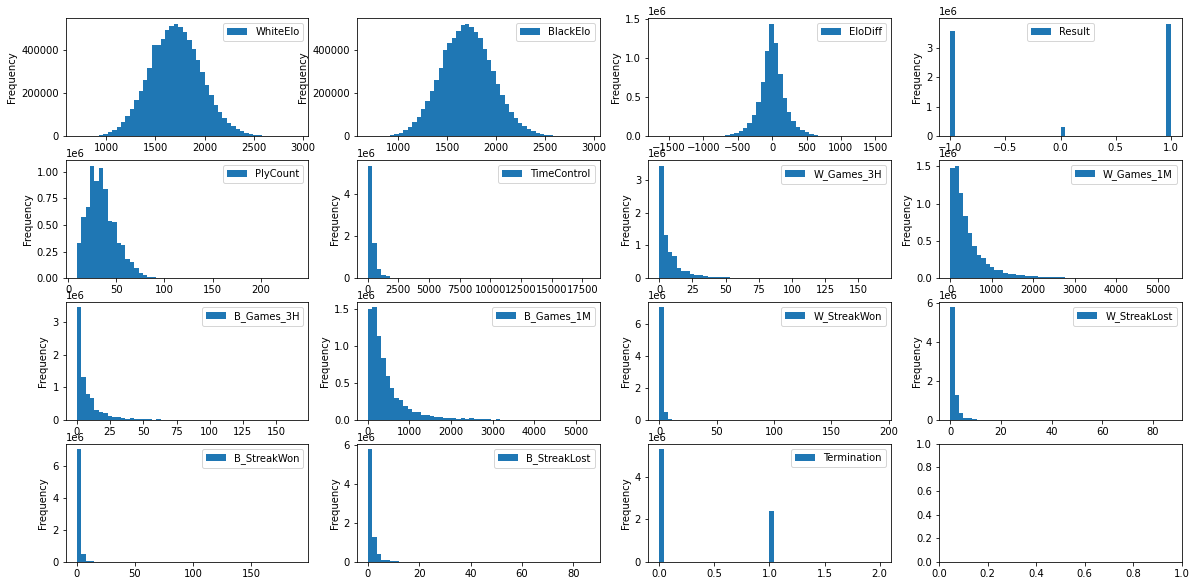

In [9]:
columns_to_plot = [
  # "White", 
  # "Black",
  "WhiteElo",
  "BlackElo",
  "EloDiff",
  "Result",
  "PlyCount",
  "TimeControl",
  "W_Games_3H",
  "W_Games_1M",
  "B_Games_3H",
  "B_Games_1M",
  "W_StreakWon",
  "W_StreakLost",
  "B_StreakWon",
  "B_StreakLost",
  "Termination",
]

fig, ax = plt.subplots(4,4,figsize=(20,10))
ax = ax.flatten()

for cc, c in enumerate(columns_to_plot): 
  ax_plot = sdf.select(c).toPandas().plot.hist(bins=50, ax=ax[cc])

### Chosen features with logarithmic scale

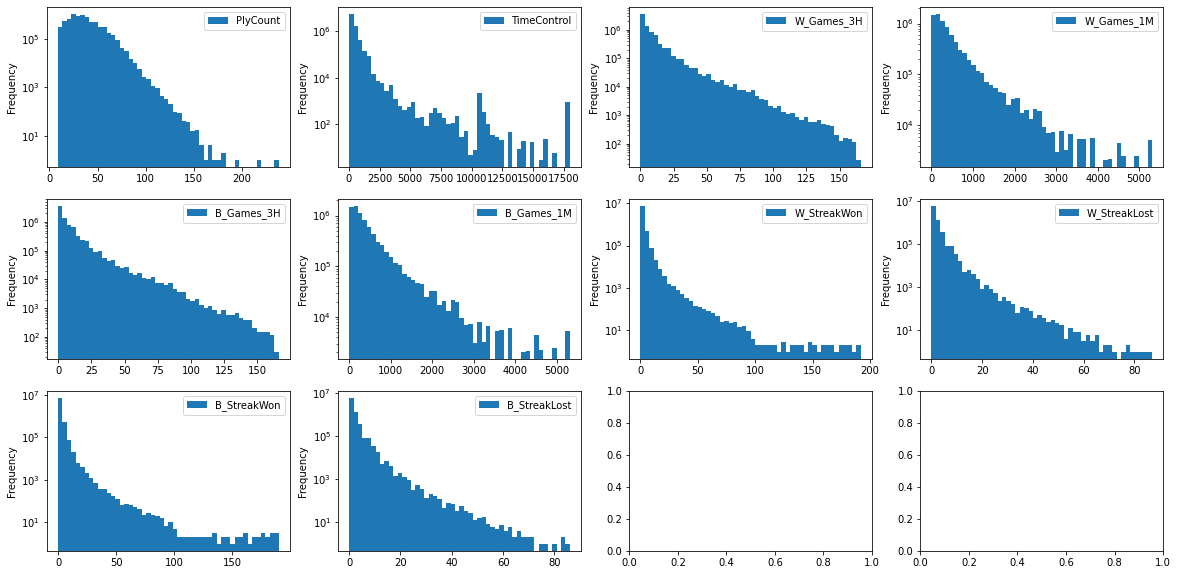

In [10]:
columns_to_plot_log = [
  "PlyCount",
  "TimeControl",
  "W_Games_3H",
  "W_Games_1M",
  "B_Games_3H",
  "B_Games_1M",
  "W_StreakWon",
  "W_StreakLost",
  "B_StreakWon",
  "B_StreakLost",
]

fig, ax = plt.subplots(3,4,figsize=(20,10))
ax = ax.flatten()
for cc, c in enumerate(columns_to_plot_log):  
  ax_plot = sdf.select(c).toPandas().plot.hist(bins=50, ax=ax[cc])

  ax_plot.set_yscale('log')

#### Distribution of the player strenght mesured by Elo number

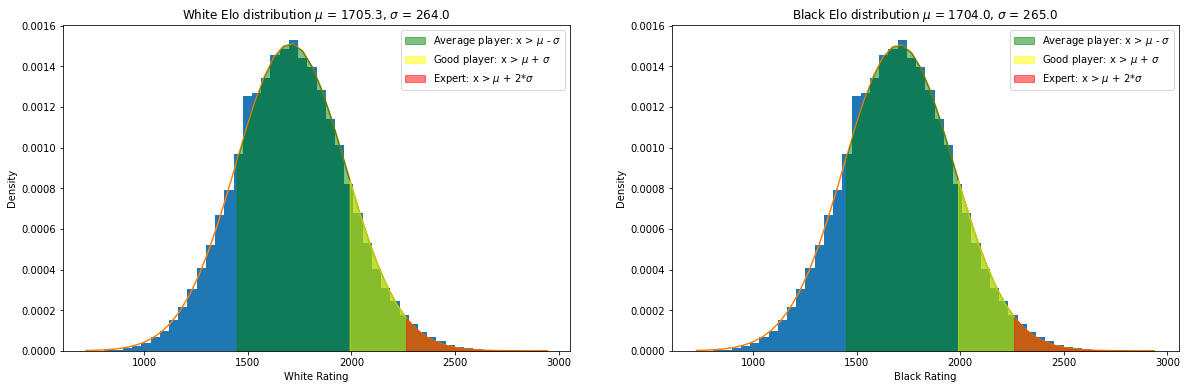

In [11]:
df = sdf[["WhiteElo", "BlackElo"]].toPandas().sample(n=int(1e6), random_state=2020)

xspan = np.array((
    np.linspace(
        df["WhiteElo"].min(), 
        df["WhiteElo"].max()
    ),
    np.linspace(
        df["BlackElo"].min(), 
        df["BlackElo"].max()
    ),
  )
).T

EloDist = np.array((
    norm.pdf(
        xspan[:,0],
        loc = df["WhiteElo"].mean(),
        scale = df["WhiteElo"].std()
    ),
    norm.pdf(
        xspan[:,1],
        loc = df["BlackElo"].mean(),
        scale = df["BlackElo"].std()
    ),
  )
).T

EloDist

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(df['WhiteElo'], density=True, alpha=1, bins=50, zorder=0)

ax1.plot(xspan[:,0], EloDist[:,0], zorder=1)

ax1.fill_between(
    xspan[:,0], EloDist[:,0], y2=0, 
    where = ( xspan[:,0] > df["WhiteElo"].mean() - df["WhiteElo"].std() ),
    zorder=2, color="green", alpha=0.5, label = "Average player: x > $\mu$ - $\sigma$ "
    )

ax1.fill_between(
    xspan[:,0], EloDist[:,0], y2=0, 
    where = ( xspan[:,0] > df["WhiteElo"].mean() + df["WhiteElo"].std() ),
    zorder=2, color="yellow", alpha=0.5, label = "Good player: x > $\mu$ + $\sigma$ "
    )

ax1.fill_between(
    xspan[:,0], EloDist[:,0], y2=0, 
    where = ( xspan[:,0] > df["WhiteElo"].mean() + 2*df["WhiteElo"].std() ),
    zorder=2, color="red", alpha=0.5, label = "Expert: x > $\mu$ + 2*$\sigma$ "
    )

ax1.set(
    xlabel='White Rating',
    ylabel='Density',
    title='White Elo distribution $\mu$ = {:.1f}, $\sigma$ = {:.1f}'.format(
        df['WhiteElo'].mean(), df['WhiteElo'].std()))
ax1.legend()

ax2.hist(df['WhiteElo'], density=True, alpha=1, bins=50, zorder=0)

ax2.plot(xspan[:,1], EloDist[:,1], zorder=1)

ax2.fill_between(
    xspan[:,1], EloDist[:,1], y2=0, 
    where = ( xspan[:,1] > df["BlackElo"].mean() - df["BlackElo"].std() ),
    zorder=2, color="green", alpha=0.5, label = "Average player: x > $\mu$ - $\sigma$ "
    )

ax2.fill_between(
    xspan[:,1], EloDist[:,1], y2=0, 
    where = ( xspan[:,1] > df["BlackElo"].mean() + df["BlackElo"].std() ),
    zorder=2, color="yellow", alpha=0.5, label = "Good player: x > $\mu$ + $\sigma$ "
    )

ax2.fill_between(
    xspan[:,1], EloDist[:,1], y2=0, 
    where = ( xspan[:,1] > df["BlackElo"].mean() + 2*df["BlackElo"].std() ),
    zorder=2, color="red", alpha=0.5, label = "Expert: x > $\mu$ + 2*$\sigma$ "
    )

ax2.set(
    xlabel='Black Rating',
    ylabel='Density',
    title='Black Elo distribution $\mu$ = {:.1f}, $\sigma$ = {:.1f}'.format(
        df['BlackElo'].mean(), df['BlackElo'].std()))
ax2.legend()

#### Is chess a fair game? Who is scoring better?

Text(0, 0.5, 'Average score')

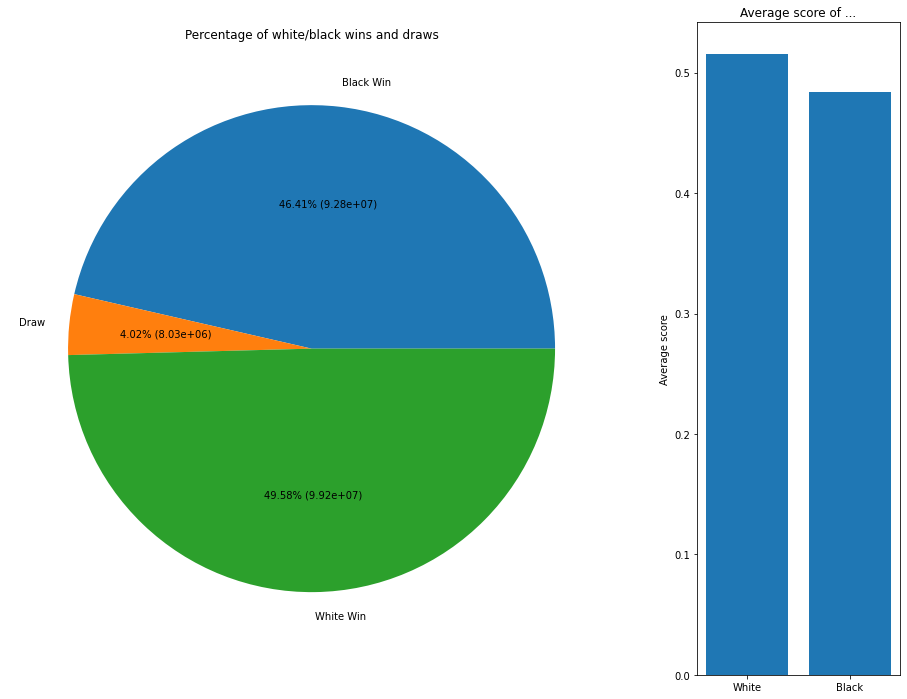

In [12]:
df = sdf[["Result"]].toPandas().sample(n=int(2e6), random_state=2020)

fig, (ax1, ax2) = plt.subplots(1,
                               2,
                               figsize=(16, 12),
                               gridspec_kw={'width_ratios': [3, 1]})
group_wins = df.groupby(['Result'])['Result'].count()

df.groupby(['Result'])['Result'].count().plot.pie(
    autopct=lambda x: '{:.2f}% ({:.2e})'.format(
        x, x * len(df)
      ),
    labels=['Black Win', 'Draw', 'White Win'],
    subplots=True,
    ax=ax1,
)

ax1.set_title('Percentage of white/black wins and draws')
ax1.set_ylabel('')

white_points = (df.groupby(['Result'])['Result'].count() /
                len(df))[0] * 0.5 + (df.groupby(['Result'])['Result'].count() /
                                     len(df))[1]
black_points = 1 - white_points

plt.bar(['White', 'Black'], [white_points, black_points], axes=ax2)
ax2.set_title('Average score of ...')
ax2.set_ylabel('Average score')

#### Most popular openings

[Text(0, 0.5, 'Relative number of games'),
 Text(0.5, 1.0, 'Most popular openings (Top 40 / 500 total)')]

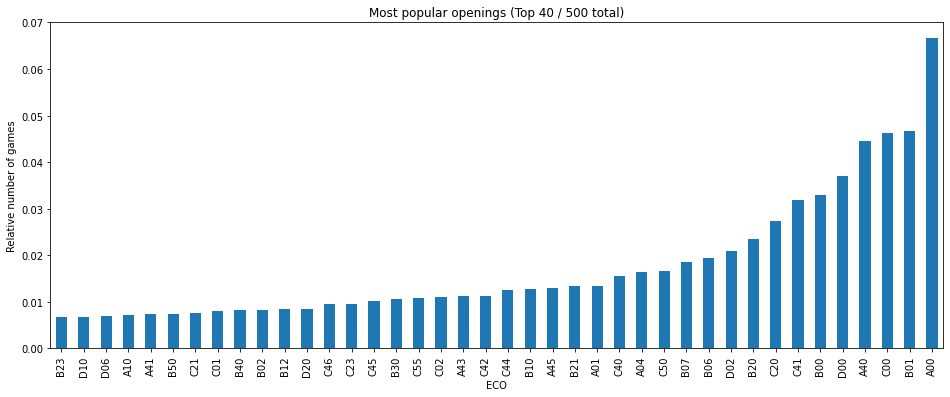

In [13]:
df = sdf[["ECO"]].toPandas().sample(n=int(1e6), random_state=2020)
Nselect = 40

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
(df.groupby(['ECO'])['ECO']
 .count().sort_values() / len(df)
).tail(Nselect).plot.bar()
ax.set(ylabel='Relative number of games',
       title='Most popular openings (Top ' + str(Nselect) + ' / '
       '500 total)')

#### Categorisize player data according to rating

In [14]:
df = sdf[["WhiteElo", "BlackElo", "ECO", "Result"]].toPandas().sample(n=int(1e6), random_state=2020)
df_pop_openings = pd.DataFrame()

FilterCols = ["WhiteElo", "BlackElo", "ECO", "Result"]
colors = ["White", "Black"] 

df_mean = df[FilterCols].mean().mean()
df_std = df[FilterCols].std().mean()

for cc, color in enumerate(colors):

    df.loc[
        df[color + "Elo"] < df_mean - df_std, color + "Elo"
    ] = 0

    df.loc[
        (
            (df[color + "Elo"] > df_mean - df_std) &
            (df[color + "Elo"] <= df_mean + df_std)
        ), color + "Elo"
    ] = 1

    df.loc[
        (
            (df[color + "Elo"] > df_mean + df_std) &
            (df[color + "Elo"] <= df_mean + 2*df_std)
        ), [color + "Elo"]  
    ] = 2

    df.loc[
        (
            df[color + "Elo"] > df_mean + 2*df_std
        ), [color + "Elo"]
    ] = 3

### Most popular openings by player categories

* If an ECO code was in the top 20 of only one or two categories, the measure for the other two was plotted as well.

[Text(0.5, 1.0, 'Most popular openings by rating group')]

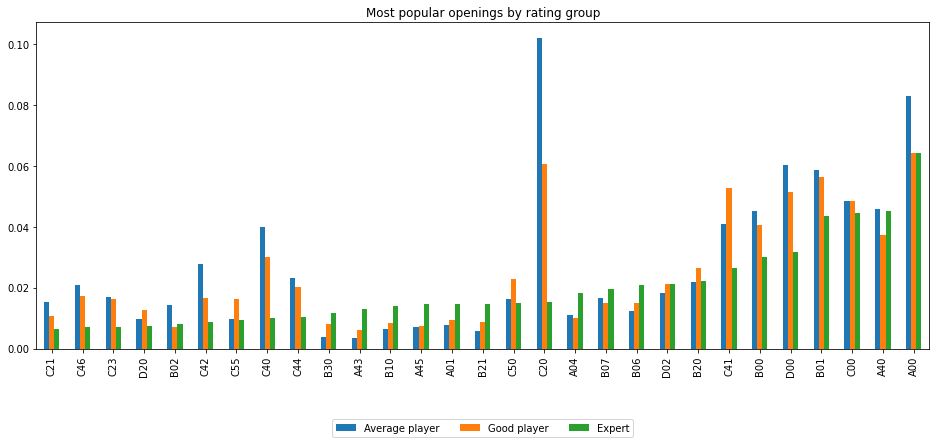

In [15]:
df_pop_openings = pd.DataFrame()

group1 = df.loc[(df['WhiteElo'] == 1) & (df['BlackElo'] == 1)].groupby(['ECO']).agg({
    'Result': 'count'
}).sort_values(by='Result', ascending=False)

group2 = df.loc[(df['WhiteElo'] == 2) & (df['BlackElo'] == 2)].groupby(['ECO']).agg({
    'Result': 'count'
}).sort_values(by='Result', ascending=False)

group3 = df.loc[(df['WhiteElo'] == 3) & (df['BlackElo'] == 3)].groupby(['ECO']).agg({
    'Result': 'count'
}).sort_values(by='Result', ascending=False)

group1 = group1 / df['Result'].loc[(df['WhiteElo'] == 1) & (df['BlackElo'] == 1)].count()
group2 = group2 / df['Result'].loc[(df['WhiteElo'] == 2) & (df['BlackElo'] == 2)].count()
group3 = group3 / df['Result'].loc[(df['WhiteElo'] == 3) & (df['BlackElo'] == 3)].count()

pop_openings1 = group1.reset_index().head(20)["ECO"].to_list()
pop_openings2 = group2.reset_index().head(20)["ECO"].to_list()
pop_openings3 = group3.reset_index().head(20)["ECO"].to_list()

pop_openings_list = list(set(pop_openings1 + pop_openings2 + pop_openings3))

for eco in pop_openings_list:
    df_pop_openings.loc[eco,"EloClass1"] = group1[group1.index.str.contains(eco)].values[0,0]
    df_pop_openings.loc[eco,"EloClass2"] = group2[group2.index.str.contains(eco)].values[0,0]
    df_pop_openings.loc[eco,"EloClass3"] = group3[group3.index.str.contains(eco)].values[0,0]

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

df_pop_openings.sort_values(by="EloClass3").plot.bar(ax=ax)
ax.legend(
    ["Average player", "Good player", "Expert"],
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
    loc='upper center')
ax.set(title='Most popular openings by rating group')

### Performance of each opening per player category

* Negative values indicate a better performance for black, while positive values correspond to better results for the white player
* Results have to be compared to the absolute number of games played in the corresponding group. Low number of games (e.g. if an opening is often played by experts and thus in the top 20, but very rarely by average players) can easily result in extreme performances. Hence, one has to make sure, that at least 100 games are played in the specific group to be more or less realistic.

[Text(0.5, 1.0, 'Most popular openings by rating group')]

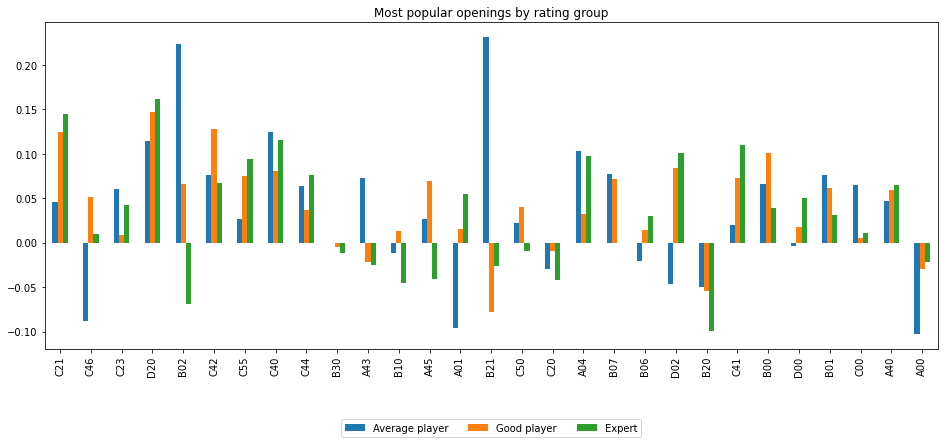

In [16]:
df_pop_openings = pd.DataFrame()

group1 = df.loc[(df['WhiteElo'] == 1) & (df['BlackElo'] == 1)].groupby(['ECO']).agg(
    Frequency = ('Result', 'count'),
    Result = ('Result', 'mean')
).sort_values(by='Frequency', ascending=False)

group2 = df.loc[(df['WhiteElo'] == 2) & (df['BlackElo'] == 2)].groupby(['ECO']).agg(
    Frequency = ('Result', 'count'),
    Result = ('Result', 'mean')
).sort_values(by='Frequency', ascending=False)

group3 = df.loc[(df['WhiteElo'] == 3) & (df['BlackElo'] == 3)].groupby(['ECO']).agg(
    Frequency = ('Result', 'count'),
    Result = ('Result', 'mean')
).sort_values(by='Frequency', ascending=False)

pop_openings1 = group1.reset_index().head(20)["ECO"].to_list()
pop_openings2 = group2.reset_index().head(20)["ECO"].to_list()
pop_openings3 = group3.reset_index().head(20)["ECO"].to_list()

pop_openings_list = list(set(pop_openings1 + pop_openings2 + pop_openings3))

for eco in pop_openings_list:
    df_pop_openings.loc[eco,"EloClass1"] = group1[group1.index.str.contains(eco)].values[0,1]
    df_pop_openings.loc[eco,"EloClass2"] = group2[group2.index.str.contains(eco)].values[0,1]
    df_pop_openings.loc[eco,"EloClass3"] = group3[group3.index.str.contains(eco)].values[0,1]
    df_pop_openings.loc[eco,"Freq_EloClass3"] = group3[group3.index.str.contains(eco)].values[0,0]

    
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

df_pop_openings.sort_values("Freq_EloClass3").drop(columns="Freq_EloClass3").plot.bar(ax=ax)

ax.legend(
    ["Average player", "Good player", "Expert"],
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
    loc='upper center')
ax.set(title='Most popular openings by rating group')

# Prediction games by machine learning

## Building and testing ML models

This chapter here is still under construction. Currently we can fit and predict the game outcome based on Random Forest and Gradient Boosting. Future work will deal with

* parameter tuning
* dimension reduction with pipelines
* cross validation
* feature hashing for player columns (white, black) and opening (eco codes)
* further modules (xgboost, pyspark.ml) 
* further algorithms
  * clustering, unlikely to work well
  * neuronal networks (interesting to test)

In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import timeit

MAX_MEMORY = "8g"

spark = SparkSession.builder.appName("DataAnalytics") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()  

sdf = spark.read.parquet("./data/2016-11/fulldb.parquet")
sdf.cache()

In [71]:
from IPython.display import clear_output

import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.feature_extraction import FeatureHasher
import xgboost as xgb

## Later, test ML algorithms from spark
# from pyspark.ml.feature import FeatureHasher
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml import Pipeline

In [3]:
dfCols = [
  "WhiteElo", "BlackElo", "EloDiff",
  "PlyCount", "TimeControl",
  "W_Games_3H", "W_Games_1M", "B_Games_3H", "B_Games_1M", 
  "W_StreakWon", "W_StreakLost",
  "B_StreakWon", "B_StreakLost",
  "Termination", "Result"
]

# Filter only games, which were played with a time control between 2 to 10 minutes 
df = sdf.filter(
    (col("TimeControl") > 120) & 
    (col("TimeControl") < 600) & 
    (col("Result") != 0)
).select(dfCols).toPandas().sample(n=int(5e5), random_state=2020)

X = df[dfCols[:-1]]
y = df[dfCols[-1]].to_numpy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size = 0.8, stratify=y, shuffle = True)

y_test = y_test[:,np.newaxis]

In [7]:
X_train

,WhiteElo,BlackElo,EloDiff,PlyCount,TimeControl,W_Games_3H,W_Games_1M,B_Games_3H,B_Games_1M,W_StreakWon,W_StreakLost,B_StreakWon,B_StreakLost,Termination
4016680,1798,1816,-18,26.0,420,0,19,6,461,5,0,0,3,0
2750453,1455,1492,-37,10.0,220,2,233,20,427,1,0,0,5,1
1604698,1127,1221,-94,24.0,300,6,329,1,170,0,11,1,0,0
2500164,1998,1878,120,47.0,180,1,490,9,80,3,0,1,0,1
217169,1836,1763,73,17.0,180,3,726,3,776,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093532,1939,1838,101,19.0,380,5,349,6,443,6,0,0,8,0
1408325,1948,2056,-108,56.0,180,11,390,20,431,1,0,0,1,1
2171286,1397,1458,-61,28.0,500,0,87,2,219,0,3,2,0,1
3880498,1307,1189,118,26.0,300,1,148,16,253,1,0,0,3,1


#### Simple baseline model based on EloDiff

* EloDiff < -10 : Result = -1 (Black wins)
* EloDiff >  10 : Result =  1 (White wins)
* -10 <= EloDiff <= 10 : Result = 0 (Draw)

In [66]:
y_pred = np.ndarray(y_test.shape)

# Version for binary results (assumed draw if EloDiff is approx 0)
# y_pred[ X_test["EloDiff"] < -10 ] = -1
# y_pred[ np.abs(X_test["EloDiff"]) <= 10 ] = 0
# y_pred[ X_test["EloDiff"] > 10 ] = 1

# Version for binary results (no draw)
y_pred[ X_test["EloDiff"] < 0 ] = -1
y_pred[ X_test["EloDiff"] >= 0 ] = 1

print('Model prediction accuracy: {:.2f} %'.format(
    np.sum(y_pred == y_test) / len(y_pred) * 100
    )
)

Model prediction accuracy: 63.79 %


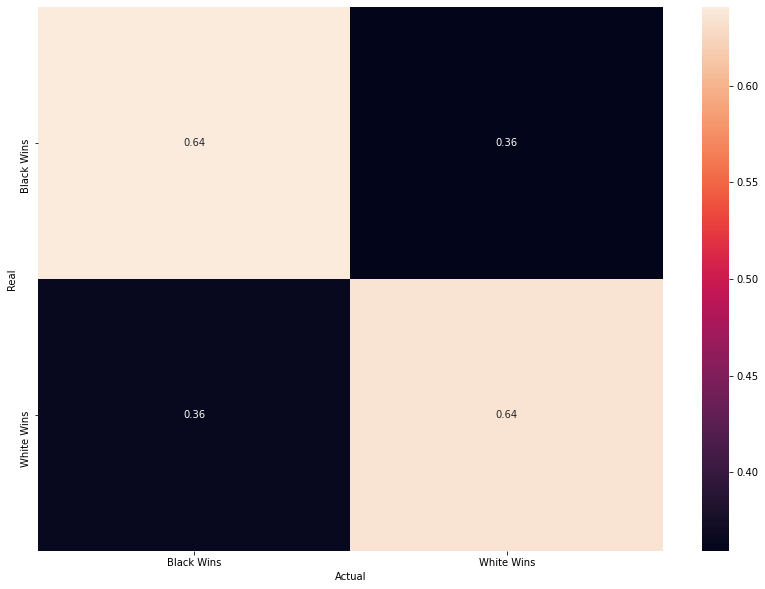

In [79]:
fig, ax1 = plt.subplots(1,1,figsize=(14,10))

cf_matrix = confusion_matrix(
    y_test, y_pred, labels=[-1, 1],
    normalize = "true"
);

sns.heatmap(
    cf_matrix,
    annot = True, 
    xticklabels=["Black Wins", "White Wins"],
    yticklabels=["Black Wins", "White Wins"],
    ax=ax1
)

ax1.set_xlabel("Actual")
ax1.set_ylabel("Real")
clear_output(wait="True")

### Random Forest Classifier (untuned)

In [81]:
model = RandomForestClassifier(max_depth = 5, n_estimators=100, max_samples=0.6, n_jobs=-1, verbose=10)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)[:,np.newaxis]

clear_output(wait="true")

print('Model prediction accuracy: {:.2f} %'.format(
    np.sum(y_pred == y_test) / len(y_pred) * 100
    )
)

Model prediction accuracy: 63.84 %


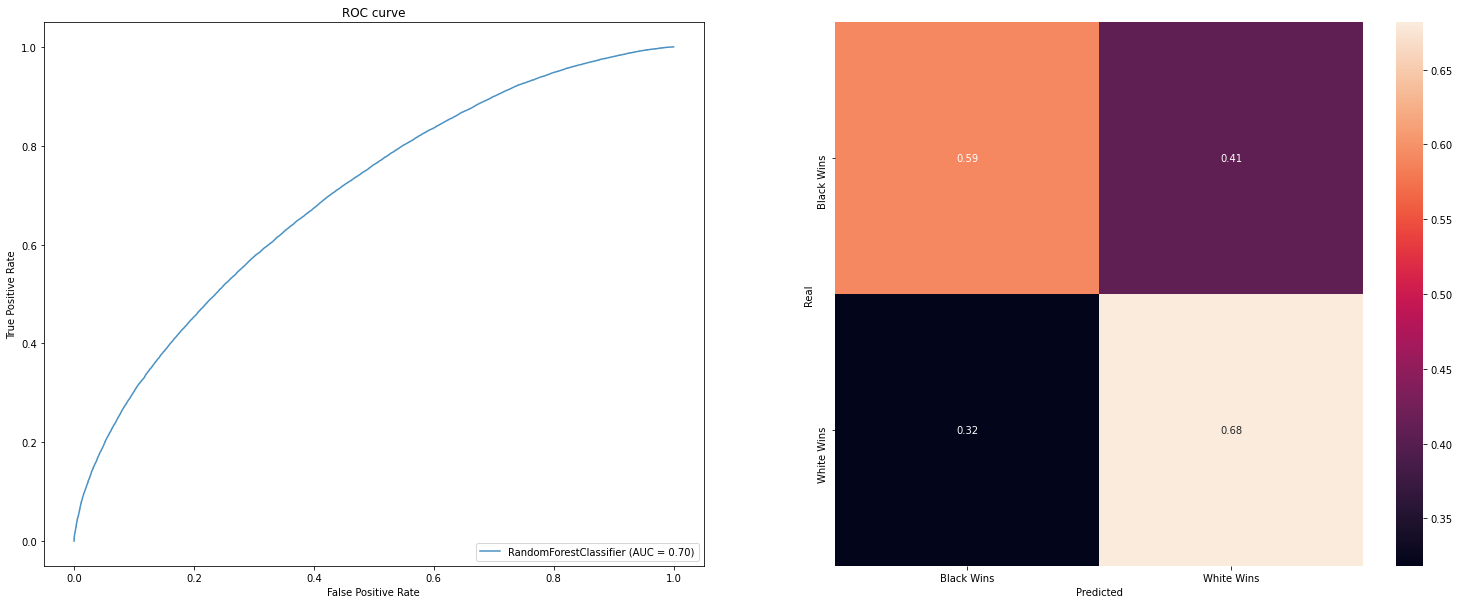

In [88]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(26,10))
rfc_disp = plot_roc_curve(model, X_test, y_test, ax=ax1, alpha=0.8);

cf_matrix = confusion_matrix(
    y_test, y_pred, normalize = "true"
);

sns.heatmap(
    cf_matrix,
    annot = True, 
    xticklabels=["Black Wins", "White Wins"],
    yticklabels=["Black Wins", "White Wins"],
    ax=ax2
)

ax1.set_title("ROC curve")

ax2.set_xlabel("Predicted")
ax2.set_ylabel("Real")
clear_output(wait="True")

Text(0, 0.5, 'Feature')

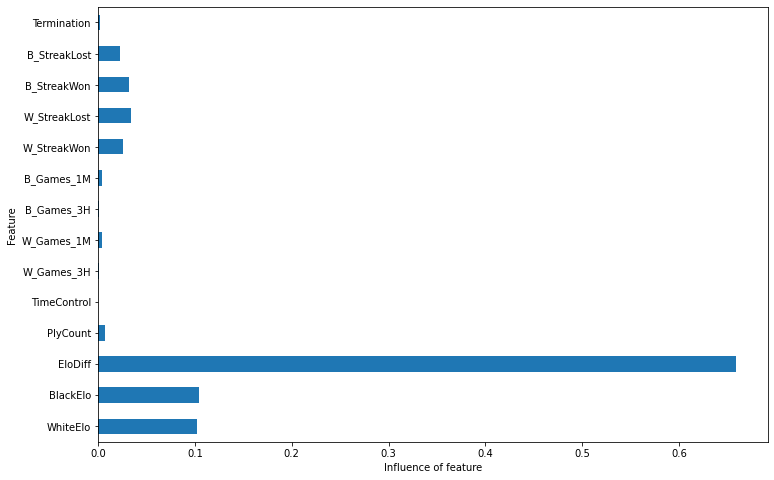

In [87]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
pd.Series(model.feature_importances_, index=X.columns).plot.barh(ax=ax)

ax.set_xlabel("Influence of feature")
ax.set_ylabel("Feature")

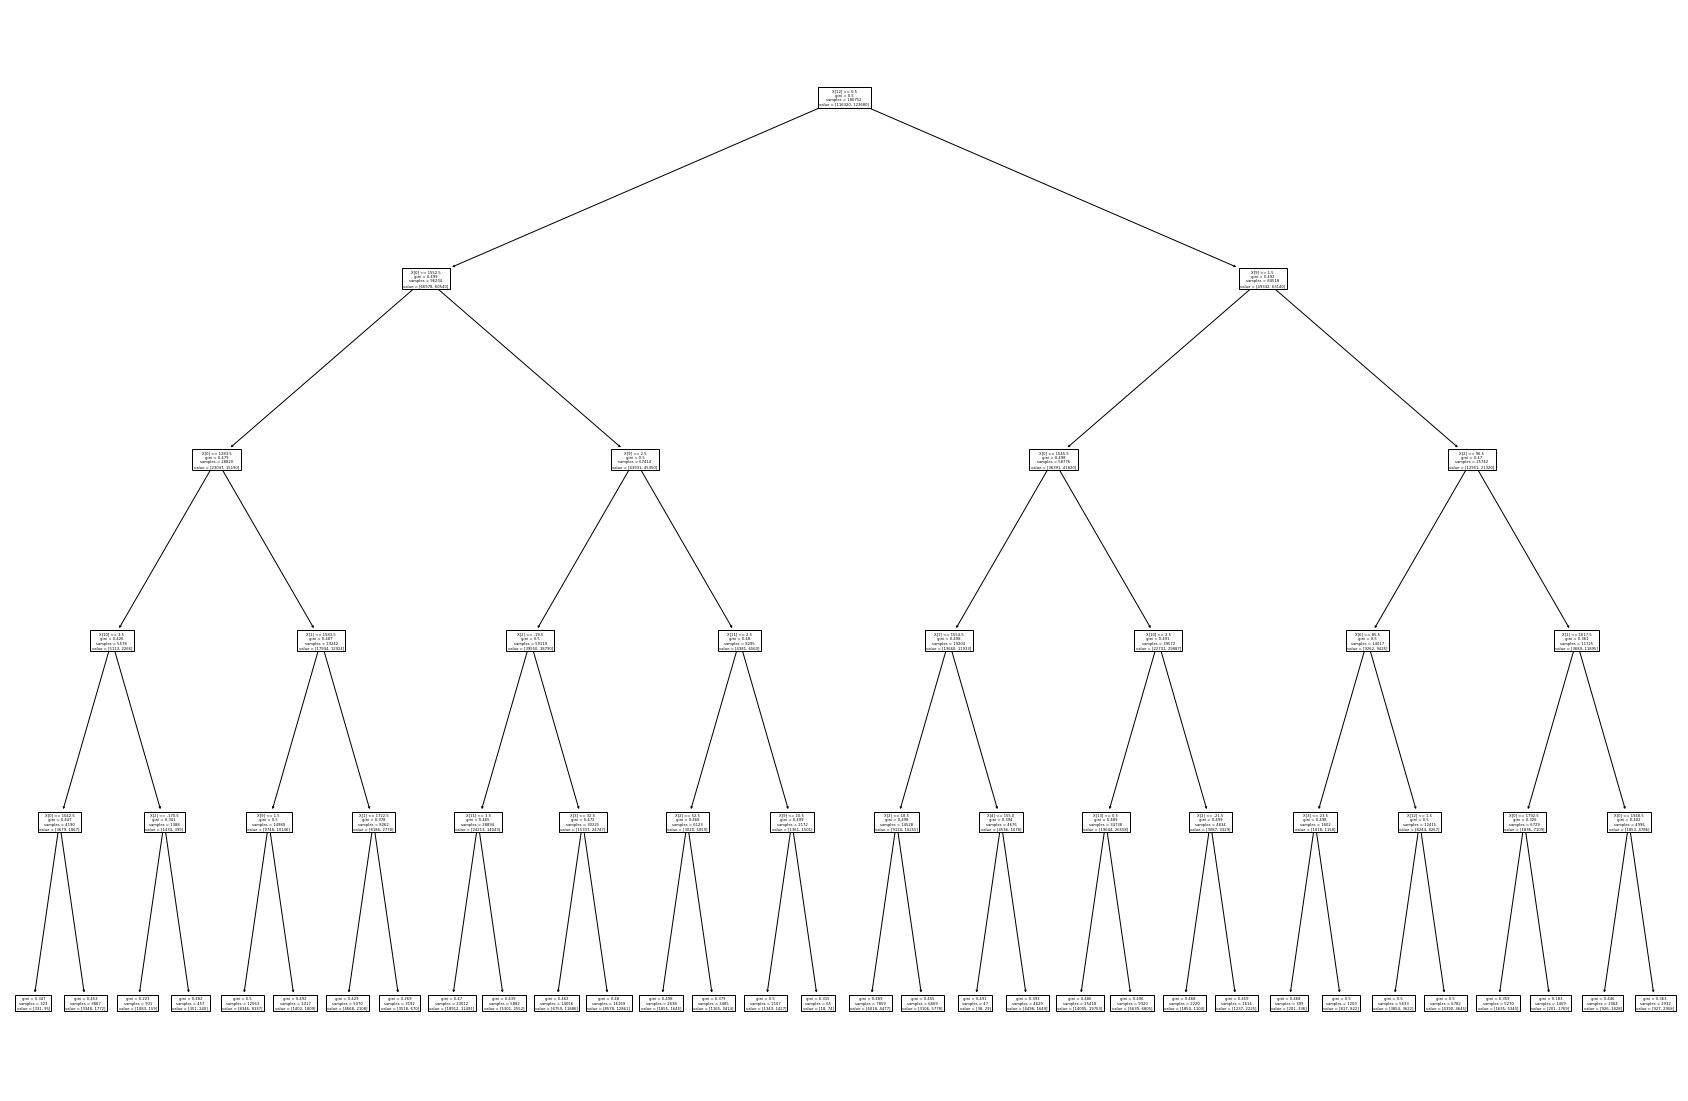

In [90]:
fig, ax = plt.subplots(1,1,figsize=(30,20))
tree.plot_tree(model[3]);

### Gradient Boosting (under construction)

In [ ]:
model = GradientBoostingClassifier(max_depth=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)[:,np.newaxis]

acc = np.sum(y_pred == y_test) / len(y_test)
acc

In [ ]:
(pd.Series(model.feature_importances_, index=X.columns)
  #  .nlargest(4)
   .plot(kind='barh')
)

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(30,20))
# tree.plot_tree(model)
# model

In [ ]:
acc = np.sum(y_pred == y_test) / len(y_test)
acc

In [ ]:
dX_train = xgb.DMatrix(X_train, label=y_train)
dX_test = xgb.DMatrix(X_test, label=y_test)


# param = {'eta': 1}
# param['nthread'] = 2
# param['eval_metric'] = 'error'
param = {}

num_round = 10
evallist = [(dX_train, 'train')]

bst = xgb.train(param, dX_train, num_round, evallist)
ypred = bst.predict(dX_test)
acc = np.sum(y_pred == y_test) / len(y_test)
acc

In [ ]:
acc = np.sum(y_pred == y_test) / len(y_test)
acc